Previously we left off after putting together a trivial filtering mechanism to filter down our data frame to job listings that were associated with data science roles. I also created a basic model for my `JobListing` object as well as setting up a database however currently the database is empty. So before I look at visualising the data a little more (as I said I would) I'll actually look at how I can import data into the database.

# Populating the Database

In [1]:
import csv
csv_file = open('/Users/dvoong/projects/data_science_jobs/raw_data/UJM-scrape-2015-07-30.csv')
reader = csv.DictReader(csv_file)
jobs = list(reader)
print jobs[0]

{'salary': '8.00 - 9.00 per hour GBP8.00 - GBP9 per hour + time and a half after 8 hours', 'noted': '2015-07-30 23:45:01.0662', 'added': '2015-07-30', 'description': 'Class 2 tipper Drivers needed for various contracts. Regular work Mon - Fri Days Must have relevant experience Digi card CPC cARD Apply', 'reference': 'Tipper_1438261410', 'title': 'Class 2 Tipper Drivers', 'career': '', 'company': 'LMR', 'job_type': 'Full time', 'jobid': '17750894', 'contact': '', 'location': 'UK-TT-Newcastle upon Tyne', 'apply': 'http://www.aplitrak.com/?adid=RGFtaWVubS41NDUwMy41ODE4QGxtci5hcGxpdHJhay5jb20', 'education': '', 'industry': 'Staffing/employment agencies'}


In [7]:
# setup django
import os
os.environ['DJANGO_SETTINGS_MODULE'] = 'data_science_jobs.settings'
os.chdir('/Users/dvoong/projects/data_science_jobs/source')
from data_exploration.models import JobListing

job = jobs[0]
try: 
    del(job['contact']) # contact information is not in the JobListing model
except KeyError: # incase I already deleted 'contact' already
    pass
job = JobListing(**job)
print job

JobListing object


Just to help with debugging what's happening I'm going to change the way the `JobListing` object displays itself when it prints. To my model I add the `__str__` method which handles this for me.

`from django.db import models`

`class JobListing(models.Model):`
    
    jobid = models.IntegerField(primary_key=True)
    title = models.CharField(max_length=100)
    location = models.CharField(max_length=100)
    salary = models.CharField(max_length=300)
    career = models.CharField(max_length=100)
    company = models.CharField(max_length=100)
    industry = models.CharField(max_length=100)
    job_type = models.CharField(max_length=100)
    education = models.CharField(max_length=100)
    description = models.CharField(max_length=10000)
    apply = models.CharField(max_length=500)
    reference = models.CharField(max_length=100)
    #    contact = models.CharField(max_length=)
    added = models.DateField()
    noted = models.CharField(max_length=100)

    def	__str__(self):
        return '{}: {}: {}'.format(self.__class__.__name__, self.jobid, self.title)

Here I do a bit a manipulation to reload the `models` module and hence the `JobListing` class.

In [33]:
import data_exploration.models

In [34]:
reload(data_exploration.models)

<module 'data_exploration.models' from 'data_exploration/models.pyc'>

In [39]:
JobListing = models.JobListing # reasign the JobListing variable

In [40]:
job = JobListing(**jobs[0]) # create a new job listign

In [41]:
print job

JobListing: 17750894: Class 2 Tipper Drivers


That looks a bit better. Note I've created a job listing object but now I need to save it to the database, this is done with the `save()` method.

In [42]:
job.save()

OperationalError: no such table: data_exploration_joblisting

FAIL! This is because I haven't initialised the table yet. To do this you need to run the command `python manage.py makemigrations` from inside the django project directory followed by a `python manage.py migrate`.

In [44]:
job.save()

This time it looks like it worked, to check this we can look at all the `JobListing` objects saved in the database.

In [45]:
JobListing.objects.all()

[<JobListing: JobListing: 17750894: Class 2 Tipper Drivers>]

There it is, but I just realsied that I forgot to run my filter so I only have datascience jobs. I'll need to remove that last entry. 

For whatever reason I couldn't delete it from ipython notebook, some error about the AppRegistryNotReady. So I cheated and went into the django shell with the command, `python manage.py shell` from my terminal and deleted it with that.

    >>> from data_exploration.models import JobListing
    >>> JobListing.objects.first().delete()

I did a bit of digging around and the error was `django.core.exceptions.AppRegistryNotReady: Models aren't loaded yet.`. After looking around stackoverflow the solution is to run a `django.setup()` after setting the `DJANGO_SETTINGS_MODULE` environment variable. To summarise: To setup a django environment without using `python manage.py shell` you need to do something like:

    import os
    os.environ['DJANGO_SETTINGS_MODULE'] = 'data_science_jobs.settings'
    import django
    django.setup()
    
And to prove it,

In [55]:
import os
os.environ['DJANGO_SETTINGS_MODULE'] = 'data_science_jobs.settings'
import django
django.setup()

In [57]:
job = JobListing(**jobs[0])
job.save()
print JobListing.objects.all()
JobListing.objects.first().delete()
print JobListing.objects.all()

[<JobListing: JobListing: 17750894: Class 2 Tipper Drivers>]
[]


Nice!!!! I wonder what would happen if I tried to save the same job twice, the jobid is being used as my primary key so it should throw and error.

In [62]:
job1 = JobListing(**jobs[0])
job2 = JobListing(**jobs[0])
job1.save()
print JobListing.objects.all()
job2.save()
print JobListing.objects.all()
len(JobListing.objects.all())

[<JobListing: JobListing: 17750894: Class 2 Tipper Drivers>]
[<JobListing: JobListing: 17750894: Class 2 Tipper Drivers>]


1

Oh, it just ignores the next entry. Well that behaviour works for me so I'll leave it at that. Now let's populate the database with data science jobs.

In [66]:
JobListing.objects.all().delete()

In [69]:
for job in jobs:
    if ('data science' in job['title'].lower() or 
    'data scientist' in job['title'].lower() or 
    'data science' in job['description'].lower() or
    'data scientist' in job['description'].lower()):
        try:
            del(job['contact'])
        except KeyError:
            pass
        job = JobListing(**job)
        job.save()
    
    

In [70]:
print JobListing.objects.all()
print len(JobListing.objects.all()) # should be 44

[<JobListing: JobListing: 17705848: Senior Clinical Data Manager>, <JobListing: JobListing: 17705946: Lead Developer / Development Manager>, <JobListing: JobListing: 17705951: Data Scientist / Data Analyst - SQL R Python Hadoop>, <JobListing: JobListing: 17708607: Analyst Programmer Data Matlab R OOD Maths>, <JobListing: JobListing: 17709538: Lead Developer / Development Manager>, <JobListing: JobListing: 17709658: ResearchSpace Research Assistant>, <JobListing: JobListing: 17710794: Senior Clinical Data Manager>, <JobListing: JobListing: 17713107: Graduate BI Business Analyst>, <JobListing: JobListing: 17714129: Mid-Range Data Analyst>, <JobListing: JobListing: 17714558: Senior Clinical Data Manager>, <JobListing: JobListing: 17717792: Senior Clinical Data Manager>, <JobListing: JobListing: 17718071: Big Data Developer - Big Data Engineer - Hadoop / Elasticsearch>, <JobListing: JobListing: 17719211: Data Analyst / Visualization Specialist>, <JobListing: JobListing: 17719316: Regulator

Awesome, it works. Now what... I can either go down the path of getting the rest of the data from the other dates, perhaps set up some automation to automatically update the database everyday with the data from zios (the web scraper guys) or I can go down the path of doing some actual data analysis, I'm going to go with the latter.

# Data analysis and visualisation

So what do I want to know? Let's list a few things you might want to know about the data,
- How many jobs are posted every day? Is the number on the rise i.e. is data science a growing field?
- What is the distribution of salaries? How does it vary with time?
- What skills are employers looking for? Python, R, Hadoop, Machine Learning? Which skills pay the best?
- What sector are data scientist jobs in? Finance, research, web?
- How does salary vary as function of geographical location?
- How do skills vary as a function of the sector?
- Where are the jobs as a function of location, sector, skills? Where is the demand?

## How many jobs are posted everyday?
Here's an example of where having more data would be good, I only have the data jobs that were on the universal jobmatch site on the 31st of July 2015. There should be a little spread of how long the jobs have been up, maybe as much as a month. Each job listing has an atrribute called `added` so this should be fairly easy to do. To start let's load the data back into a dataframe.

### Converting database objects into a dataframe

In [71]:
from pandas import Series, DataFrame

In [94]:
df = DataFrame([j.__dict__ for j in JobListing.objects.all()])

I really should have mentioned dataframes before. They are a useful way to store data temporarily in memory that is easy and fast to work with, e.g. data cleaning, munging, pivoting, mapping and general purpose manipulation. As well as this they also have many inbuilt statistical functionality such as quickly seeing the mean, median, standard deviation, etc. of numerical data. Having data store in an Object orientated way such as with the Django ORM is great for looking at interactions between objects, but sometimes you just need a big f\*\*king table to do some data analysis.

You can instantiate a dataframe in many different ways, I'm a fan of using a list of dictionary objects, the keys of each dictionary go on to become the column names of the data frame. Here each dictionary object has the same keys (the attributes of my `JobListing` object). However I get an extra `_state` attribute, not really sure what it is but I don't need it so I'll remove it and while I'm at it I'll update the index to correspond to the `jobid` of the job listing.

In [96]:
df.index = df['jobid']
df = df.drop('_state', 1)
df = df.drop('jobid', 1)

In [100]:
df

,added,apply,career,company,description,education,industry,job_type,location,noted,reference,salary,title
jobid,,,,,,,,,,,,,
17705848,2015-07-29,http://www.uk-recruitment.net/job/senior-clini...,,UK Recruitment,inVentiv Health -Transforming Promising Ideas ...,,Staffing/employment agencies,Full time,UK-London-London Central/West End,2015-07-29 23:50:28.306272,100004008405,,Senior Clinical Data Manager
17705946,2015-07-29,http://www.uk-recruitment.net/job/lead-develop...,,UK Recruitment,Lead Developer / Development Manager Internati...,,Staffing/employment agencies,Full time,UK-London-London Central/West End,2015-07-29 23:50:56.107772,100004008210,,Lead Developer / Development Manager
17705951,2015-07-29,http://www.uk-recruitment.net/job/data-scienti...,,UK Recruitment,Data Scientist / Data Analyst - SQL R Python H...,,Staffing/employment agencies,Full time,UK-London-London Central/West End,2015-07-29 23:50:57.795561,100004008199,,Data Scientist / Data Analyst - SQL R Python H...
17708607,2015-07-29,http://www.technojobs.co.uk/job.phtml/1981300?...,,Technojobs,Analyst Programmer / Data Software Engineer / ...,,Staffing/employment agencies,Full time,UK-HC-Surrey,2015-07-29 23:47:50.368271,1981300,50000,Analyst Programmer Data Matlab R OOD Maths
17709538,2015-07-29,http://www.adzuna.co.uk/jobs/land/ad/297966105...,,Adzuna,Lead Developer / Development Manager Internati...,,Internet services,Full time,UK-London-London South East,2015-07-29 23:56:07.255843,ADZ/297966105,"50,000.00 - 50,000.00 per year £50,000 per annum",Lead Developer / Development Manager
17709658,2015-07-29,http://www.adzuna.co.uk/jobs/land/ad/298160064...,,Adzuna,Ancient Egypt and Sudan Fixed Term – 12 months...,,Internet services,Full time,UK-London-London South West,2015-07-29 23:56:46.829761,ADZ/298160064,"37,830.00 - 44,298.00 per year £37,830 - £44, ...",ResearchSpace Research Assistant
17710794,2015-07-29,http://www.uk-recruitment.net/job/senior-clini...,,UK Recruitment,inVentiv Health -Transforming Promising Ideas ...,,Staffing/employment agencies,Full time,UK-London-London Central/West End,2015-07-30 00:02:15.917876,100004035184,,Senior Clinical Data Manager
17713107,2015-07-29,http://www.reed.co.uk/jobs/graduate-bi-busines...,,reed.co.uk,This is an exciting opportunity to join one of...,,Staffing/employment agencies,Full time,UK-London-London,2015-07-30 01:11:55.485206,27659015,"24,000.00 - 30,000.00 per year",Graduate BI Business Analyst
17714129,2015-07-29,http://www.uk-recruitment.net/job/mid-range-da...,,UK Recruitment,Digital Gurus are currently working with an in...,,Staffing/employment agencies,Full time,UK-London-London Central/West End,2015-07-30 21:40:21.622774,100004030965,,Mid-Range Data Analyst


So in my head I'm envisioning some sort of bar chart with the date on the x-axis and the number of jobs posted on that date on the y-axis. What I need is to take my data frame and manipulate it so I end up with a data frame where the row index will be a data and there will be one column with the number of jobs posted on that date. This is called aggregating the data.

I want to group by the date and aggregate the data by counting job posted on that date.

In [136]:
dates = df.groupby('added').count()
dates

,apply,career,company,description,education,industry,job_type,location,noted,reference,salary,title
added,,,,,,,,,,,,
2015-07-27,2,2,2,2,2,2,2,2,2,2,2,2
2015-07-28,2,2,2,2,2,2,2,2,2,2,2,2
2015-07-29,25,25,25,25,25,25,25,25,25,25,25,25
2015-07-30,15,15,15,15,15,15,15,15,15,15,15,15


Ewww a lot of redundant data there, the OCD in me requests I clean this up

In [137]:
dates = DataFrame(index=dates.index, data=dates['apply'])

In [138]:
dates.columns = ['count']
dates

,count
added,
2015-07-27,2
2015-07-28,2
2015-07-29,25
2015-07-30,15


### Plotting using `matplotlib`
You can plot this data in a bar chart using the `matplotlib` library. ipython notebook has the additional feature of being able to plot inline into the notebook, set this up using the command,

In [130]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


This imports various modules such as the `matplotlib.pyplots` module under the alias `plt`

In [131]:
plt

<module 'matplotlib.pyplot' from '/Users/dvoong/projects/data_science_jobs/virtualenv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

(735805.0, 735810.0)

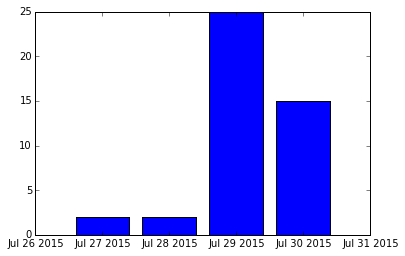

In [301]:
import matplotlib.dates as mdates

# date_format = mdates.DateFormatter('%d/%m')
plt.bar(dates.index, dates.values, align="center")
ax = plt.axes()
# ax.xaxis.set_major_formatter(date_format)
datemin = dates.index.min() - datetime.timedelta(days=1)
datemax = dates.index.max() + datetime.timedelta(days=1)
ax.set_xlim(datemin, datemax)

Well there's not much to say about that, other than perhaps posts don't last very long on the old jobs board. We'll have to wait until we have more data before we can say anything conclusive on that, at least all the data manipulation and visualisation methods are in place.

## What is the distribution of salaries? How does it vary with time?
This one is a little tricker, the salaries column stores a string rather than an actual number so we need to take a few things into consideration.
- Is the value an annual salary, pay by the hour, pay per contract?
- Is the salary prefixed by a £ symbol?
- Does the salary contain commas or apostrophes or neither to indicate a thousand?
- Does the salary contain a range depending on things such as experience?
- Benefits? Bonuses?
- Do salaries contain non integer values?

Here are what some of the salaries look like,

In [312]:
filter = df['salary'] != ''
salaries = df[filter]
salaries = salaries['salary']
salaries


jobid
17708607                                                50000
17709538     50,000.00 - 50,000.00 per year £50,000 per annum
17709658    37,830.00 - 44,298.00 per year £37,830 - £44, ...
17713107                       24,000.00 - 30,000.00 per year
17719211                                 Salary not specified
17719316                                   Competitive salary
17724055                                        Not disclosed
17732349                       20,000.00 - 30,000.00 per year
17732352                       25,000.00 - 40,000.00 per year
17732887                       20,000.00 - 30,000.00 per year
17737523    85,000.00 - 100,000.00 per year Bonus, Benefit...
17737540                       40,000.00 - 40,000.00 per year
17738420                      70,000.00 - 100,000.00 per year
17738499                       35,000.00 - 60,000.00 per year
17738621                                           negoitable
17740833    25,000.00 - 35,000.00 per year training + bene...
17

Let's start out by filtering the easy ones and then try to build on that. This type of development is called an inside-out type of strategy, you start with something simple and build something more complex from it. This is a very natural approach to take however there are disadvantages to this, such as not being able to see the whole picture which may lead to unnecessary code and code that is difficult to maintain. Later I intend to return to this problem with an outside in approach and a comprehensive test suite, but for the sake of exploring the data I'll go along with an inside out approach.

Looking at the first result we see a fairly simple case.

In [313]:
salaries = DataFrame(salaries)

In [315]:
def convert_to_numerical(salary_string):
    salary = None
    try:
        salary = int(salary_string)
    except Exception as e:
        print e
    return salary

salaries['salary_numerical'] = salaries['salary'].map(convert_to_numerical)

invalid literal for int() with base 10: '50,000.00 - 50,000.00 per year \xa350,000 per annum'
invalid literal for int() with base 10: '37,830.00 - 44,298.00 per year \xa337,830 - \xa344, 298 (pro rata) per annum'
invalid literal for int() with base 10: '24,000.00 - 30,000.00 per year'
invalid literal for int() with base 10: 'Salary not specified'
invalid literal for int() with base 10: 'Competitive salary'
invalid literal for int() with base 10: 'Not disclosed'
invalid literal for int() with base 10: '20,000.00 - 30,000.00 per year'
invalid literal for int() with base 10: '25,000.00 - 40,000.00 per year'
invalid literal for int() with base 10: '20,000.00 - 30,000.00 per year'
invalid literal for int() with base 10: '85,000.00 - 100,000.00 per year Bonus, Benefits and Training'
invalid literal for int() with base 10: '40,000.00 - 40,000.00 per year'
invalid literal for int() with base 10: '70,000.00 - 100,000.00 per year'
invalid literal for int() with base 10: '35,000.00 - 60,000.00 pe

In [316]:
salaries

,salary,salary_numerical
jobid,,
17708607,50000,50000
17709538,"50,000.00 - 50,000.00 per year £50,000 per annum",NaN
17709658,"37,830.00 - 44,298.00 per year £37,830 - £44, ...",NaN
17713107,"24,000.00 - 30,000.00 per year",NaN
17719211,Salary not specified,NaN
17719316,Competitive salary,NaN
17724055,Not disclosed,NaN
17732349,"20,000.00 - 30,000.00 per year",NaN
17732352,"25,000.00 - 40,000.00 per year",NaN


That's three down, let's try getting something with a £ sign in the front. The second item is a good candidate, however there is a range of salaries, for now I'll just take the first one I come across.

In [354]:
import re

def convert_to_numerical(salary_string):
    print u'salary_string: {}'.format(salary_string)
    salary = None
    try:
        salary = int(salary_string)
    except Exception as e:
        print e
        
    if salary == None:
        regex = u"£\d+,\d+"
        m = re.search(regex, salary_string)
        try:
            salary = int(m.group(0).replace(u'£', '').replace(',', ''))
        except Exception as e:
            print e
    print 'salary_numerical: {}'.format(salary)
    
    print
    return salary

salaries['salary_numerical'] = salaries['salary'].map(convert_to_numerical)

salary_string: 50000
salary_numerical: 50000

salary_string: 50,000.00 - 50,000.00 per year £50,000 per annum
invalid literal for int() with base 10: '50,000.00 - 50,000.00 per year \xa350,000 per annum'
salary_numerical: 50000

salary_string: 37,830.00 - 44,298.00 per year £37,830 - £44, 298 (pro rata) per annum
invalid literal for int() with base 10: '37,830.00 - 44,298.00 per year \xa337,830 - \xa344, 298 (pro rata) per annum'
salary_numerical: 37830

salary_string: 24,000.00 - 30,000.00 per year
invalid literal for int() with base 10: '24,000.00 - 30,000.00 per year'
'NoneType' object has no attribute 'group'
salary_numerical: None

salary_string: Salary not specified
invalid literal for int() with base 10: 'Salary not specified'
'NoneType' object has no attribute 'group'
salary_numerical: None

salary_string: Competitive salary
invalid literal for int() with base 10: 'Competitive salary'
'NoneType' object has no attribute 'group'
salary_numerical: None

salary_string: Not disclose

In [336]:
salaries

,salary,salary_numerical
jobid,,
17708607,50000,50000
17709538,"50,000.00 - 50,000.00 per year £50,000 per annum",50000
17709658,"37,830.00 - 44,298.00 per year £37,830 - £44, ...",37830
17713107,"24,000.00 - 30,000.00 per year",NaN
17719211,Salary not specified,NaN
17719316,Competitive salary,NaN
17724055,Not disclosed,NaN
17732349,"20,000.00 - 30,000.00 per year",NaN
17732352,"25,000.00 - 40,000.00 per year",NaN


Getting there gradually, next numbers without a prefixed pounds symbol, with a thousands separator and with an optional decimal point followed by two digits.

In [353]:
import re

def convert_to_numerical(salary_string):
    print u'salary_string: {}'.format(salary_string)
    salary = None
    try:
        salary = int(salary_string)
    except Exception as e:
        print e
        
    if salary == None:
        regex = u"£\d+,\d+"
        m = re.search(regex, salary_string)
        try:
            salary = int(m.group(0).replace(u'£', '').replace(',', ''))
        except Exception as e:
            print e
    
    if salary == None:
        regex = "\d+,\d+(\.\d{2})?"
        m = re.search(regex, salary_string)
        try:
            salary = int(float(m.group(0).replace(u'£', '').replace(',', '')))
        except Exception as e:
            print e
    
    print 'salary_numerical: {}'.format(salary)
    print
    return salary

salaries['salary_numerical'] = salaries['salary'].map(convert_to_numerical)

salary_string: 50000
salary_numerical: 50000

salary_string: 50,000.00 - 50,000.00 per year £50,000 per annum
invalid literal for int() with base 10: '50,000.00 - 50,000.00 per year \xa350,000 per annum'
salary_numerical: 50000

salary_string: 37,830.00 - 44,298.00 per year £37,830 - £44, 298 (pro rata) per annum
invalid literal for int() with base 10: '37,830.00 - 44,298.00 per year \xa337,830 - \xa344, 298 (pro rata) per annum'
salary_numerical: 37830

salary_string: 24,000.00 - 30,000.00 per year
invalid literal for int() with base 10: '24,000.00 - 30,000.00 per year'
'NoneType' object has no attribute 'group'
salary_numerical: 24000

salary_string: Salary not specified
invalid literal for int() with base 10: 'Salary not specified'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
salary_numerical: None

salary_string: Competitive salary
invalid literal for int() with base 10: 'Competitive salary'
'NoneType' object has no attribute 'group'
'NoneTy

In [340]:
salaries

,salary,salary_numerical
jobid,,
17708607,50000,50000
17709538,"50,000.00 - 50,000.00 per year £50,000 per annum",50000
17709658,"37,830.00 - 44,298.00 per year £37,830 - £44, ...",37830
17713107,"24,000.00 - 30,000.00 per year",24000
17719211,Salary not specified,NaN
17719316,Competitive salary,NaN
17724055,Not disclosed,NaN
17732349,"20,000.00 - 30,000.00 per year",20000
17732352,"25,000.00 - 40,000.00 per year",25000


Just testing my regular expression here, nothing to see carry on.

In [343]:
regex = "\d+,\d+(\.\d{2})?"
m = re.search(regex, "23,000.23")
m.group(0)

'23,000.23'

In [344]:
regex = "\d+,\d+(\.\d{2})?"
m = re.search(regex, "23,000")
m.group(0)

'23,000'

Okay that looks good enough for a first round. Let's collate it all together.

In [347]:
df['salary_numerical'] = df['salary'].map(convert_to_numerical)


salary_string: 
invalid literal for int() with base 10: ''
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
salary_numerical: None


salary_string: 
invalid literal for int() with base 10: ''
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
salary_numerical: None


salary_string: 
invalid literal for int() with base 10: ''
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
salary_numerical: None

50000
salary_string: 50000
salary_numerical: 50000

50,000.00 - 50,000.00 per year £50,000 per annum
salary_string: 50,000.00 - 50,000.00 per year £50,000 per annum
invalid literal for int() with base 10: '50,000.00 - 50,000.00 per year \xa350,000 per annum'
salary_numerical: 50000

37,830.00 - 44,298.00 per year £37,830 - £44, 298 (pro rata) per annum
salary_string: 37,830.00 - 44,298.00 per year £37,830 - £44, 298 (pro rata) per annum
invalid literal for int() with base 10: '37,830.0

And now I'll put it in a more readable format.

In [352]:
df[['title', 'salary_numerical', 'industry', 'location', 'description']].sort('salary_numerical', ascending=False)

,title,salary_numerical,industry,location,description
jobid,,,,,
17737523,"Senior Data Scientist (Data Mining, RSPSS, R, ...",85000,Other/not classified,UK-London-City of London,"Senior Data Scientist (Data Mining, RSPSS, R, ..."
17738420,Big Consultant (SAS/R/Matlab/Python),70000,Internet services,UK-London-City,Big Data Scientist Consultant - Perm - Managem...
17708607,Analyst Programmer Data Matlab R OOD Maths,50000,Staffing/employment agencies,UK-HC-Surrey,Analyst Programmer / Data Software Engineer / ...
17709538,Lead Developer / Development Manager,50000,Internet services,UK-London-London South East,Lead Developer / Development Manager Internati...
17748108,Data Analyst (Analytics) - Online Gaming Group...,50000,Staffing/employment agencies,UK-London-London East,Want to join this 'world class' tech/game deve...
17748111,Data Analyst (Analytics) - Online Gaming Group...,50000,Staffing/employment agencies,UK-London-London East,Want to join this 'world class' tech/game deve...
17737540,Product Manager - Programmatic Trading Platform,40000,Other/not classified,UK-London-London,Product Manager - Programmatic Trading Platfor...
17709658,ResearchSpace Research Assistant,37830,Internet services,UK-London-London South West,Ancient Egypt and Sudan Fixed Term – 12 months...
17738499,Erlang Developer,35000,Internet services,UK-SW-Bath,I'm currently working on behalf of an exciting...


### Results of salary mining
So far it looks pretty decent, there are still a few issues though
- Not enough data to cover edge cases
- Salaries are sometimes in the description or even title
- Some jobs are not really data scientist jobs, e.g. business data analyst jobs (though that is more an issue with my data science filter)
- A plot showing the distribution would be useful, a histogram would be better than a bar chart in this case
- Perhaps the mean of a salary range would be a more meaningful value to show rather than the lower bound?
- Some patterns starting to show, some relevant keywords such as senior, lead, SAS, Matlab, data analyst, etc. What exactly is the difference between an analyst and a scientist? Is the scientist the next level up?

For now I'll leave it at that and contemplate some of the other questions before coming back to this later.
